In [3]:
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [4]:
transform = transforms.ToTensor() #definido q conversãao de imagen praa tensor

trainset = datasets.MNIST('./MNIST_data/', download=True, train=True, transform=transform) # Carrega a parte de treino do dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

valset = datasets.MNIST('./MNIST_data/', download=True, train=False, transform=transform) # Carrega aparte de validação do dataset
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=True) # Cria um buffer para pegar os dados por partes

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.60MB/s]


In [7]:
print(len(trainloader))

938


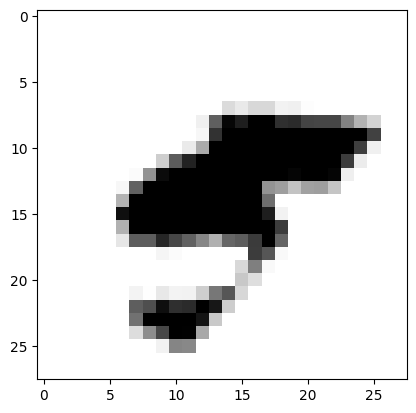

In [8]:
dataiter = iter(trainloader)
images, etiquetas = next(dataiter) # images, etiquetas = dataiter.next()

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


In [9]:
print(images[0].shape) #para verificar as dimensões do tensor de cada imagen
print(etiquetas[0].shape) #para verificar as dimensoes do tensor de cada etiqueta


torch.Size([1, 28, 28])
torch.Size([])


In [10]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.linear1 = nn.Linear(28*28, 128)  # camada de entrada, 784 neurônios que se ligam a 128
        self.linear2 = nn.Linear(128, 64)     # camada interna 1, 128 neurônios que se ligam a 64
        self.linear3 = nn.Linear(64, 10)      # camada interna 2, 64 neurônios que se ligam a 10
        # para a camada de saída não é necessário definir nada pois só precisamos pegar o output da camada interna 2

    def forward(self, X):
        X = F.relu(self.linear1(X))  # função de ativação da camada de entrada para a camada interna 1
        X = F.relu(self.linear2(X))  # função de ativação da camada interna 1 para a camada interna 2
        X = self.linear3(X)          # camada de saída, sem ativação (logits)
        return F.log_softmax(X, dim=1)  # dados utilizados para calcular a perda

In [11]:
def treino(modelo, trainloader, device):

    otimizador = optim.SGD(modelo.parameters(), lr=0.01, momentum=0.5)  # define a política de atualização dos pesos e da bias
    inicio = time()  # timer para sabermos quanto tempo levou o treino

    criterio = nn.NLLLoss()  # definindo o critério para calcular a perda
    EPOCHS = 10  # número de epochs que o algoritmo rodará
    modelo.train()  # ativando o modo de treinamento do modelo

    for epoch in range(EPOCHS):
        perda_acumulada = 0  # inicialização da perda acumulada da epoch em questão

        for imagens, etiquetas in trainloader:

            imagens = imagens.view(imagens.shape[0], -1) # convertendo as imagens para "vetores" de 28*28 casas
            otimizador.zero_grad()  # zerando os gradientes por conta do ciclo anterior

            output = modelo(imagens.to(device)) # colocando os dados no modelo
            perda_instantanea = criterio(output, etiquetas.to(device))  # calculando a perda
            perda_instantanea.backward()  # backpropagation
            otimizador.step()  # atualizando os pesos e a bias

            perda_acumulada += perda_instantanea.item() # atualização da perda acumulada


        else:
            print("Epoch {} - Perda resultante: {}".format(epoch + 1, perda_acumulada / len(trainloader)))
        print("\nTempo de treino (em minutos) =", (time() - inicio) / 60)

In [12]:
def validacao(modelo, valloader, device):
    conta_corretas, conta_todas = 0, 0

    for imagens, etiquetas in valloader:
        for i in range(len(etiquetas)):

            img = imagens[i].view(1, 784)

            # desativar o autograd para acelerar a validação.
            # Grafos computacionais dinâmicos têm um custo alto de processamento
            with torch.no_grad():
                # output do modelo em escala logarítmica
                logps = modelo(img.to(device))

            ps = torch.exp(logps) # converte output para escala normal (lembrando que é um tensor)
            probab = list(ps.cpu().numpy()[0]) # converte o tensor em um número, no caso, o número que o modelo previu correto
            etiqueta_pred = probab.index(max(probab))
            etiqueta_certa = etiquetas.numpy()[i]
            if etiqueta_certa == etiqueta_pred:  # compara a previsão com o valor correto
                conta_corretas += 1
            conta_todas += 1

    print("Total de imagens testadas =", conta_todas)
    print("\nPrecisão do modelo = {}%".format(conta_corretas * 100 / conta_todas))

In [13]:
modelo = Modelo() #inicializa o modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
modelo.to(device)

Modelo(
  (linear1): Linear(in_features=784, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=64, bias=True)
  (linear3): Linear(in_features=64, out_features=10, bias=True)
)

In [14]:
treino(modelo, trainloader, device)
validacao(modelo, valloader, device)

Epoch 1 - Perda resultante: 1.1661192041946882

Tempo de treino (em minutos) = 0.15582555135091145
Epoch 2 - Perda resultante: 0.3787644811467067

Tempo de treino (em minutos) = 0.3013485829035441
Epoch 3 - Perda resultante: 0.3112677648536432

Tempo de treino (em minutos) = 0.4462945977846781
Epoch 4 - Perda resultante: 0.2719358734484675

Tempo de treino (em minutos) = 0.5797690192858378
Epoch 5 - Perda resultante: 0.23957113474448608

Tempo de treino (em minutos) = 0.7244935750961303
Epoch 6 - Perda resultante: 0.21347380334189706

Tempo de treino (em minutos) = 0.870425530274709
Epoch 7 - Perda resultante: 0.19215167137478462

Tempo de treino (em minutos) = 1.001723337173462
Epoch 8 - Perda resultante: 0.1737820323028449

Tempo de treino (em minutos) = 1.1461154222488403
Epoch 9 - Perda resultante: 0.15847820777501634

Tempo de treino (em minutos) = 1.2912672281265258
Epoch 10 - Perda resultante: 0.14524010153435696

Tempo de treino (em minutos) = 1.4299570878346761
Total de imagen